In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


In [2]:
import pandas as pd
import numpy as np


# Obtain Code to AA maps with ratios

In [3]:
# get full codon from degenerate codons
GC_CODE_MAP_DICT = {'R': ['A', 'G'],
               'Y': ['C', 'T'],
               'M': ['A', 'C'],
               'K': ['G', 'T'],
               'S': ['C', 'G'],
               'W': ['A', 'T'],
               'H': ['A', 'C', 'T'],
               'B': ['C', 'G', 'T'],
               'V': ['A', 'C', 'G'],
               'D': ['A', 'G', 'T'],
               'N': ['A', 'C', 'G', 'T']}

def get_codons(degenrate_codon):
    code_maps = [GC_CODE_MAP_DICT[code]  if code in GC_CODE_MAP_DICT else [code] for code in degenrate_codon]

    n_codons = np.prod([len(code_map) for code_map in code_maps])
    # print(f'The number of full codons for {degenrate_codon} is {n_codons}')

    codons = []
    for code_map in code_maps:
        if not codons:
            codons = code_map
        else:
            codons = [f'{c1}{c2}' for c1 in codons for c2 in code_map]
    
    ratios = len(codons) * [1 / n_codons]
    
    return codons, ratios

# # degenrate_codon = 'RCC'
# degenrate_codon = 'WGC'
# # degenrate_codon = 'DDT'
# codons, ratios = get_codons(degenrate_codon)
# codons, ratios

In [4]:
def get_codons_for_dgcs_str(dgc_str):
    if dgc_str is None or dgc_str == '' or pd.isna(dgc_str):
        return [], []
    dgc_list = dgc_str.split(',')
    codons_list = []
    ratios_list = []
    for dgc in dgc_list:
        codons, ratios = get_codons(dgc)
        codons_list.extend(codons)
        ratios_list.extend(ratios)
    
    return codons_list, ratios_list

# df_data['Degenerate_codon'].apply(get_codons_for_dgcs_str)

# df_data['codons'], df_data['codon_ratios'] = zip(*df_data['Degenerate_codon'].apply(get_codons_for_dgcs_str))
# df_data.head()

In [6]:
df_ecoli_codons = pd.read_csv('data/round1/wet-lab/ecoli_codons.txt', sep='\t')
codon2aa = dict(zip(df_ecoli_codons['Codon'], df_ecoli_codons['name']))

def codons_to_aa(codons, ratios):
    aa_list = []
    aa_ratios = []
    for codon, ratio in zip(codons, ratios):
        if codon in codon2aa:
            aa_list.append(codon2aa[codon])
        else:
            aa_list.append('X')  # Unknown amino acid

        aa_ratios.append(ratio)
    
    # group by amino acid and sum the ratios
    aa_dict = {}
    for aa, ratio in zip(aa_list, aa_ratios):
        if aa in aa_dict:
            aa_dict[aa] += ratio
        else:
            aa_dict[aa] = ratio
    
    # convert to lists
    aa_list = list(aa_dict.keys())
    aa_ratios = list(aa_dict.values())

    # normalize the ratios
    total_ratio = sum(aa_ratios)
    if total_ratio > 0:
        aa_ratios = [ratio / total_ratio for ratio in aa_ratios]

    return aa_list, aa_ratios

# codons, ratios = ['AGC', 'TGC', 'AGC'], [0.5, 0.5, 1.0]
# codons_to_aa(codons, ratios)


In [7]:
import numpy as np

def convert_into_savinase_position(positions):
    """ Convert from BPN positions to savinase positions """
    uniq_pos = list(set(positions))
    uniq_pos_sorted = np.sort(uniq_pos).tolist()

    # Convert the positions into savinase positions
    savinase = 'AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGI*STHPDLNIRGGASFVPGEPST*QDGNGHGTHVAGTIAALNNSIGVLGVAPSAELYAVKVLGASGSGSVSSIAQGLEWAGNNGMHVANLSLGSPSPSATLEQAVNSATSRGVLVVAASGNSG*AGS***ISYPARYANAMAVGATDQNNNRASFSQYGAGLDIVAPGVNVQSTYPGSTYASLNGTSMATPHVAGAAALVKQKNPSWSNVQIRNHLKNTATSLGSTNLYGSGLVNAEAATR'

    sav_pos = []
    idx_diff = 0
    for i, aa in enumerate(savinase):
        if aa == '*': idx_diff += 1

        if i+1 in uniq_pos_sorted:
            sav_pos.append(i+1 - idx_diff)
    
    # restore the original order
    pos_mapping = dict(zip(uniq_pos_sorted, sav_pos))
    sav_pos = [pos_mapping[p] for p in positions]
    return sav_pos

# convert_into_savinase_position([57])
# df_hotspot['sav_pos'] = convert_into_savinase_position(df_hotspot['pos'].values)

# Obtain position weight matrix

In [8]:
def obtain_ass_pos_freqs(df_data, mut_comb):
    fix_pos = [int(mut[1:-1]) for mut in mut_comb.split('/')]

    pos = df_data['pos_bpn'].tolist()
    ass_pos_aa_freqs = {}

    for i, row in df_data.iterrows():
        if row['pos_bpn'] in fix_pos:
            continue
        if sum(row['aa_ratios']) <= 0 :
            continue
        
        ass_pos_aa_freqs[row['pos_bpn']] = {aa: freq for aa, freq in zip(row['aa_list'], row['aa_ratios'])}
    return ass_pos_aa_freqs

# mut_comb = 'G169A/K213Y/N218S/K256N/Y217L/M50F'
# ass_pos_aa_freqs = obtain_ass_pos_freqs(df_data, mut_comb)
# ass_pos_aa_freqs

In [9]:
import ast 

nat_AAs = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
opt_pos = [2, 3, 24, 43, 50, 76, 98, 107, 124, 125, 126, 131, 152, 169, 204, 206, 209, 213, 217, 218, 222, 223, 224, 256, 271]
 
def get_pos_weight(mut_comb, aa_freqs_in_as_pos):
    fix_positions = []
    fix_aa_mut = []
    for mut in mut_comb.split('/'):
        fix_positions.append(int(mut[1:-1]))
        fix_aa_mut.append(mut[-1])
    
    weight_mat = {aa:[] for aa in nat_AAs}
    for pos in opt_pos:
        if pos in aa_freqs_in_as_pos: # associate positions
            for aa in nat_AAs:
                if aa in aa_freqs_in_as_pos[pos]:
                    weight_mat[aa].append(aa_freqs_in_as_pos[pos][aa])
                else:
                    weight_mat[aa].append(0.0)
        else:
            if pos in fix_positions:  # fixed positions
                idx = fix_positions.index(pos)
                for aa in nat_AAs:
                    if aa == fix_aa_mut[idx]:
                        weight_mat[aa].append(1.0)
                    else:
                        weight_mat[aa].append(0.0)
            else:  # other positions
                for aa in nat_AAs:
                    weight_mat[aa].append(0.0)
    
    weight_mat_df = pd.DataFrame(weight_mat)
    weight_mat_df['pos'] = opt_pos
    weight_mat_df.sort_values(by=['pos'], inplace=True)
    weight_mat_df[nat_AAs] = weight_mat_df[nat_AAs].div(weight_mat_df[nat_AAs].sum(axis=1), axis=0).replace(np.nan, 0)
    
    return fix_positions, weight_mat_df.reset_index()

# mut_comb = 'G169A/K213Y/N218S/K256N/Y217L/M50F'
# fix_positions, weight_mat_df = get_pos_weight(mut_comb, ass_pos_aa_freqs)
# display(weight_mat_df)

In [10]:
import logomaker
from utils import plot_style_utils

def draw_weblogo(weight_mat_df, fix_positions, path=None):

    plot_style_utils.set_pub_plot_context(context="talk")
    fig, ax = plot_style_utils.simple_ax(figsize=(14, 3))
    plot_style_utils.prettify_ax(ax)

    ww_logo = logomaker.Logo(weight_mat_df[nat_AAs], font_name='Arial', ax=ax,
                             color_scheme='NajafabadiEtAl2017', vpad=.1, width=.8)

    # style using Logo methods
    ww_logo.style_spines(visible=False)
    ww_logo.style_spines(spines=['left', 'bottom'], visible=True)
    ww_logo.style_xticks(rotation=45, fmt='%d', anchor=0) #

    # style using Axes methods
    ww_logo.ax.set_ylabel("bits", labelpad=-1)
    ww_logo.ax.set_xticklabels(list(weight_mat_df.pos))
    ww_logo.ax.xaxis.set_ticks_position('none')
    ww_logo.ax.xaxis.set_tick_params(pad=-1)
    
    # highlight positions
    for pos in fix_positions:
        ww_logo.highlight_position(p=list(weight_mat_df.pos).index(pos), color='gold', alpha=.5)
    
    if path is not None:
        plot_style_utils.save_for_pub(fig, path=path)

# draw_weblogo(weight_mat_df, fix_positions, path='figures/round1/r1_mc1_weblogo_wetlab')

# MC1

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


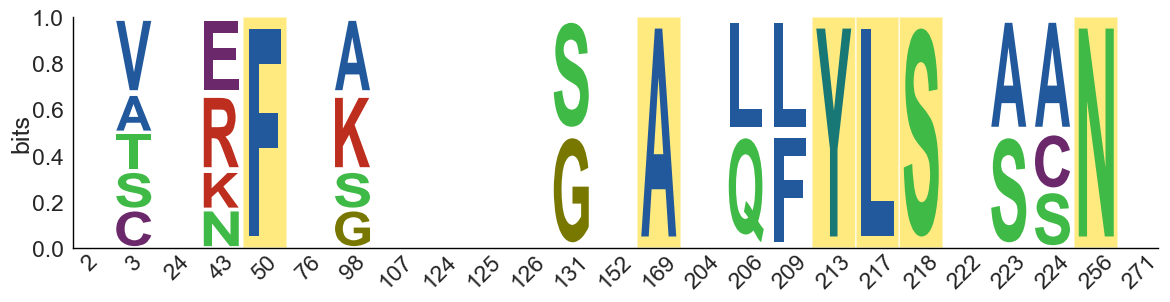

In [11]:
def draw_wetlab_weblogo(mut_comb, mc_name):
    df_data = pd.read_excel('data/round1/wet-lab/lib_synthesis.xlsx', sheet_name=mc_name)
    df_data['codons'], df_data['codon_ratios'] = zip(*df_data['Degenerate_codon'].apply(get_codons_for_dgcs_str))

    bpn2sav_pos = {pos: savi_pos for pos, savi_pos in zip(list(range(1, 275+1)), convert_into_savinase_position(list(range(1, 275+1))))}
    savi2bpn_pos = {v: k for k, v in bpn2sav_pos.items()}

    df_data['aa_list'], df_data['aa_ratios'] = zip(*df_data.apply(lambda row: codons_to_aa(row['codons'], row['codon_ratios']), axis=1))
    df_data['pos_bpn'] = df_data['Pos'].apply(lambda x: savi2bpn_pos[x] if pd.notna(x) else None)

    df_data.to_csv(f'data/round1/wet-lab/lib_synthesis_with_codons_{mc_name}.csv', index=False)
    # df_data.head()

    ass_pos_aa_freqs = obtain_ass_pos_freqs(df_data, mut_comb)
    fix_positions, weight_mat_df = get_pos_weight(mut_comb, ass_pos_aa_freqs)
    # display(weight_mat_df)

    draw_weblogo(weight_mat_df, fix_positions, path=f'figures/round1/r1_{mc_name}_weblogo_wetlab')

mut_comb = 'G169A/K213Y/N218S/K256N/Y217L/M50F'
mc_name = 'MC1'
draw_wetlab_weblogo(mut_comb, mc_name)

# MC2

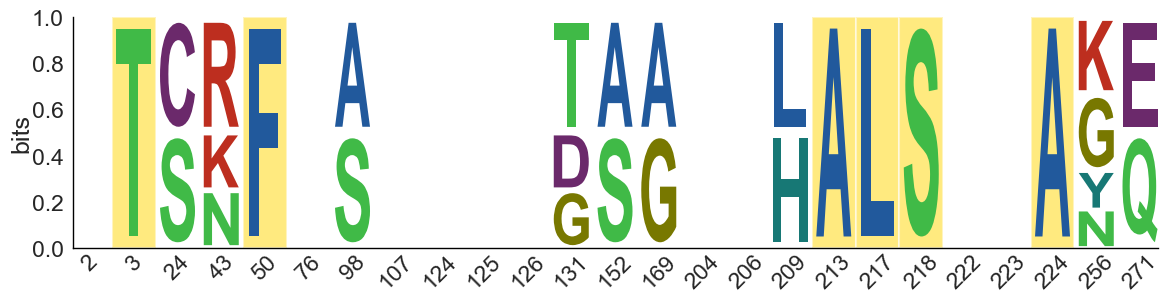

In [12]:
draw_wetlab_weblogo('S3T/M50F/K213A/Y217L/N218S/T224A', 'MC2')

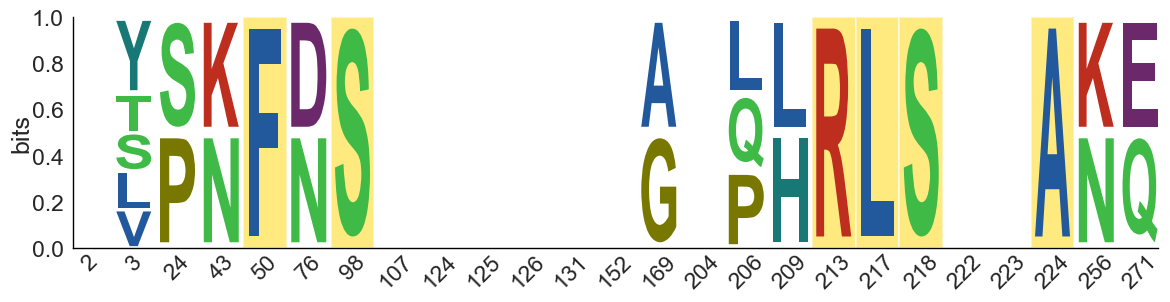

In [13]:
draw_wetlab_weblogo('M50F/A98S/K213R/Y217L/N218S/T224A', 'MC3')

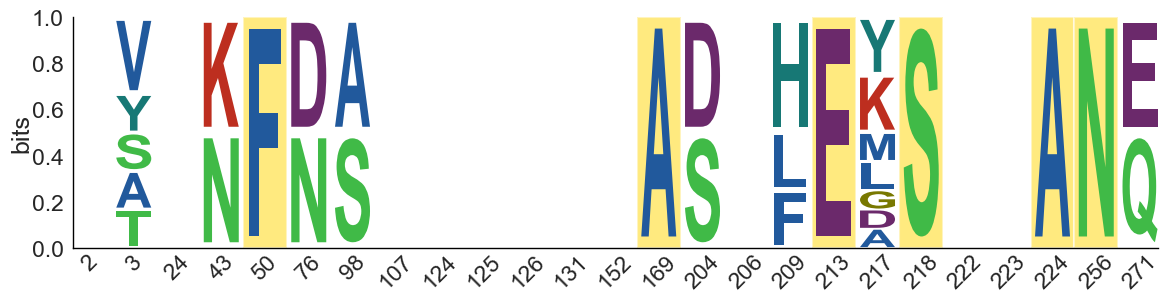

In [14]:
draw_wetlab_weblogo('M50F/G169A/K213E/N218S/T224A/S256N', 'MC4')